# Load Dataset

In [ ]:
%rm -rf /content/*
!git clone https://github.com/hmda77/Machine-Learning-Class

%mv /content/Machine-Learning-Class/Neural_Network/'Acoustic Features Classification'/* /content/
%rm -rf /content/Machine-Learning-Class/

Cloning into 'Machine-Learning-Class'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 61 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (61/61), done.


# Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, classification_report, auc
import seaborn as sns

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid
import torchvision
import torchvision.transforms as transforms


# Preproccess data

In [ ]:
data = pd.read_csv("/content/HW2_Acoustic Features.csv")
data.head(5)

,Class,_RMSenergy_Mean,_Lowenergy_Mean,_Fluctuation_Mean,_Tempo_Mean,_MFCC_Mean_1,_MFCC_Mean_2,_MFCC_Mean_3,_MFCC_Mean_4,_MFCC_Mean_5,...,_Chromagram_Mean_9,_Chromagram_Mean_10,_Chromagram_Mean_11,_Chromagram_Mean_12,_HarmonicChangeDetectionFunction_Mean,_HarmonicChangeDetectionFunction_Std,_HarmonicChangeDetectionFunction_Slope,_HarmonicChangeDetectionFunction_PeriodFreq,_HarmonicChangeDetectionFunction_PeriodAmp,_HarmonicChangeDetectionFunction_PeriodEntropy
0,relax,0.052,0.591,9.136,130.043,3.997,0.363,0.887,0.078,0.221,...,0.426,1.000,0.008,0.101,0.316,0.261,0.018,1.035,0.593,0.970
1,relax,0.125,0.439,6.680,142.240,4.058,0.516,0.785,0.397,0.556,...,0.002,1.000,0.000,0.984,0.285,0.211,-0.082,3.364,0.702,0.967
2,relax,0.046,0.639,10.578,188.154,2.775,0.903,0.502,0.329,0.287,...,0.184,0.746,0.016,1.000,0.413,0.299,0.134,1.682,0.692,0.963
3,relax,0.135,0.603,10.442,65.991,2.841,1.552,0.612,0.351,0.011,...,0.038,1.000,0.161,0.757,0.422,0.265,0.042,0.354,0.743,0.968
4,relax,0.066,0.591,9.769,88.890,3.217,0.228,0.814,0.096,0.434,...,0.004,0.404,1.000,0.001,0.345,0.261,0.089,0.748,0.674,0.957


In [ ]:
# split data & label
X_train = data.iloc[:, 1:].values.astype(np.float32)
Y_train = data.iloc[:, 0].values

data_classes = ['relax', 'happy', 'sad', 'angry']
d = dict(zip(data_classes, range(0,4)))
Y_train = data.iloc[:, 0].map(d, na_action='ignore').values
# Y_train = preprocessing.scale(Y_train)

# make Train & validation set
train_set, test_set, train_labels, test_labels = train_test_split(X_train, Y_train, stratify=Y_train,
                                                                      random_state= 231,test_size=0.20)
train_set, val_set, train_labels, val_labels = train_test_split(train_set, train_labels, stratify=train_labels,
                                                                      random_state= 312,test_size=0.10)

In [ ]:
print(train_set.shape,val_set.shape,test_set.shape)
print(train_labels.shape,val_labels.shape,test_labels.shape)

(288, 50) (32, 50) (80, 50)
(288,) (32,) (80,)


## normalize data

In [ ]:
# preproccess data
train_set = preprocessing.scale(train_set)
val_set = preprocessing.scale(val_set)
test_set = preprocessing.scale(test_set)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:254: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably v

## make dataloader

In [ ]:
# prepare dataset for torch
train_set_tensor = torch.tensor(train_set)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_set_tensor, train_labels_tensor)
train_loader = DataLoader(train_tensor, batch_size=16, num_workers=2, shuffle=True)

val_set_tensor = torch.tensor(val_set)
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_set_tensor, val_labels_tensor)
val_loader =   DataLoader(val_tensor, batch_size=16, num_workers=2, shuffle=True)

test_set_tensor = torch.tensor(test_set)
test_labels_tensor = torch.tensor(test_labels)
test_tensor = TensorDataset(test_set_tensor, test_labels_tensor)
test_loader = DataLoader(test_tensor, batch_size=16, num_workers=2, shuffle=False)

# Functions  for Train, evaluation and Test

In [ ]:
def train_model(model,train_loader,num_epoch):
    model.train()
    exp_lr_scheduler.step()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
            
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                num_epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.data))
            
def evaluate(model,data_loader):
    model.eval()
    loss = 0
    acc = 0
    correct = 0
    
    for data, target in data_loader:
        data = data.unsqueeze(1)
        data, target = data, target
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        output = model(data)
        
        loss += F.cross_entropy(output, target, size_average=False).data

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    acc = 100. * correct / len(data_loader.dataset)
    return loss.cpu(), acc.cpu()

In [ ]:
def get_output(model, loader, with_prob=True):
    y_pred, y_true, = [], []
    loss = 0
    correct = 0
    if with_prob:
        y_prob = []
    else:
        y_prob = None
    for inputs, labels in loader:
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = model(inputs)
        loss += F.cross_entropy(outputs, labels, size_average=False).data
        _, preds = torch.max(outputs, 1)
        if with_prob:
            probs = torch.nn.functional.softmax(outputs, dim=1)
        else:
            probs = None
        y_pred.append(preds.cpu().numpy())
        y_true.append(labels.cpu().numpy())
        if with_prob:
            y_prob.append(probs.detach().cpu().numpy())

        correct += preds.eq(labels.data.view_as(preds)).cpu().sum()

    loss /= len(loader.dataset)
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))
    y_pred = np.concatenate(y_pred)
    y_true = np.concatenate(y_true)
    if with_prob:
        y_prob = np.concatenate(y_prob)
    return y_pred, y_true, y_prob

# Report Functions

In [ ]:
# Make the confusion matrix
def confusion_plot(y_test,y_pred):
    cmt = confusion_matrix(y_test,y_pred)
    plt.rcParams['figure.figsize'] = (10,8)
    sns.heatmap(cmt,fmt='',annot=True,linewidth=0.01,cmap=sns.cubehelix_palette(as_cmap=True))
    plt.title("confusion matrix heat map")
    plt.xlabel("predicted")
    plt.ylabel("true")
    plt.show()


# generate classification report
def generate_classification_report(y_test,y_pred):
    report=pd.DataFrame.from_dict(classification_report(y_pred,y_test,output_dict=True)).T
    report['Label']=[i  if x.isdigit() else " " for i,x in enumerate(report.index)]
    report=report[['Label','f1-score','precision','recall','support']]
    pd.set_option('display.max_rows', report.shape[0]+1)
    return report

# ROC Curve
def plot_roc_curve(y_test,proba,pos_label):
    fpr, tpr, thresholds = roc_curve(y_test, proba[:,pos_label], pos_label= pos_label)
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')

    plt.rcParams['figure.figsize'] = (10,8)
    plt.plot(fpr, tpr,'k:',lw=5, label='average ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0 ,1],[0 ,1],'r')
    plt.legend(loc="lower right")
    plt.title('ROC Curve for {0}'.format(pos_label))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# ROC Curve for all classes
def plot_roc_curve_all(y_test,proba,n_class,figsize):
    plt.figure(figsize=figsize)
    for i in range(n_class):
      fpr, tpr, thresholds = roc_curve(y_test, proba[:,i], pos_label= i)
      plt.plot(fpr, tpr,lw=3, label = data_classes[i])
    plt.plot([0 ,1],[0 ,1],'r')
    roc_auc = roc_auc_score(y_test, proba, multi_class='ovr')
    plt.title('ROC Curve for all classes, auc score = {}'.format(roc_auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

# Network 1 hidden layer 2048 ReLU as Act. Func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(
            nn.Dropout(0.1),

            nn.Linear(50,2048),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(2048,4),
            nn.Softmax(),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

## add optimizar and loss function

In [ ]:
ann_model = Net()
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

## Training

In [ ]:
num_epochs = 100
loss_per_epoch = np.array([])
acc_per_epoch = np.array([])
for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    lpe,ape = evaluate(ann_model, val_loader)
    loss_per_epoch = np.append(loss_per_epoch,lpe)
    acc_per_epoch = np.append(acc_per_epoch,ape)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)



Average Val Loss: 1.0434, Val Accuracy: 22/32 (68.750%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 1.1779, Val Accuracy: 18/32 (56.250%)


Average Val Loss: 1.0788, Val Accuracy: 21/32 (65.625%)


Average Val Loss: 1.0487, Val Accuracy: 22/32 (68.750%)


Average Val Loss: 1.0099, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0434, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0416, Val Accuracy: 22/32 (68.750%)


Average Val Loss: 1.0545, Val Accuracy: 22/32 (68.750%)


Average Val Loss: 1.0870, Val Accuracy: 21/32 (65.625%)


Average Val Loss: 1.0599, Val Accuracy: 22/32 (68.750%)


Average Val Loss: 1.0562, Val Accuracy: 22/32 (68.750%)


Average Val Loss: 1.0326, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0249, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0249, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0249, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0249, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0249, Val Accuracy: 23/32 (71.875%)


Average Val Loss: 1.0249, Val Accuracy: 23/32 (71.875%)


Average Val L

### Training Plot

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa0ae8bb1f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py", line 1424, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


Text(0, 0.5, 'Loss')

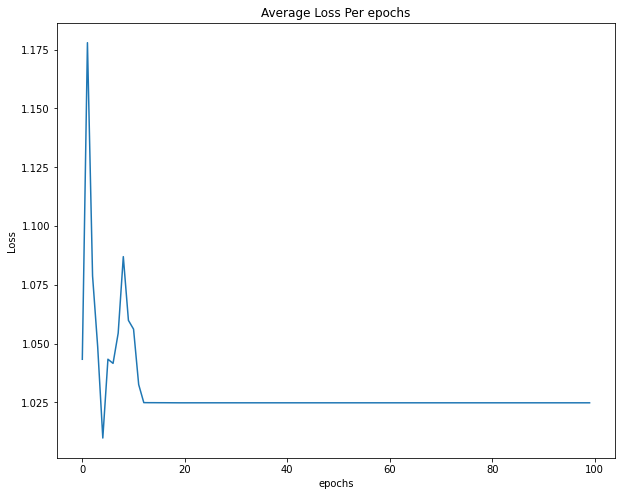

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),loss_per_epoch)
plt.title('Average Loss Per epochs')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

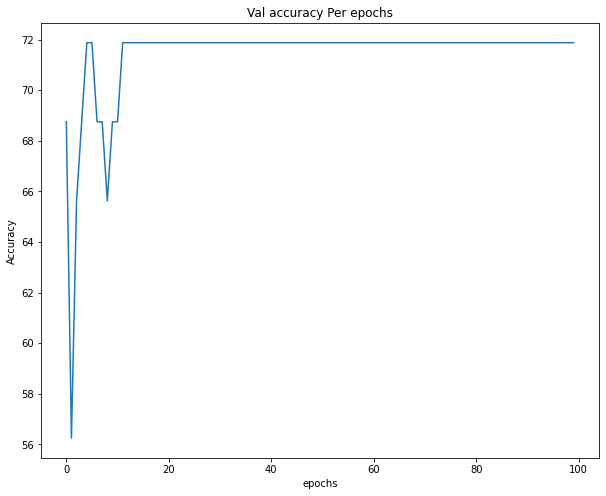

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),acc_per_epoch)
plt.title('Val accuracy Per epochs')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
y_pred, y_true, y_prob = get_output(ann_model,test_loader)


Average Val Loss: 1.0990, Val Accuracy: 51/80 (63.750%)



/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## report classification

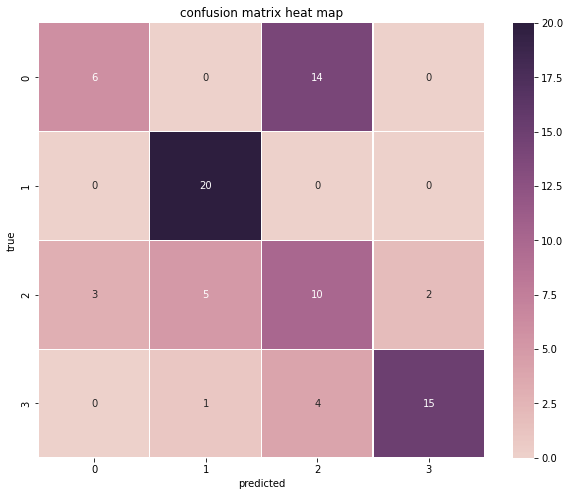

In [ ]:
# Make the confusion matrix
confusion_plot(y_true,y_pred)

In [ ]:
generate_classification_report(y_true,y_pred)

,Label,f1-score,precision,recall,support
0,0,0.413793,0.300000,0.666667,9.0000
1,1,0.869565,1.000000,0.769231,26.0000
2,2,0.416667,0.500000,0.357143,28.0000
3,3,0.810811,0.750000,0.882353,17.0000
accuracy,,0.637500,0.637500,0.637500,0.6375
macro avg,,0.627709,0.637500,0.668848,80.0000
weighted avg,,0.647291,0.693125,0.637500,80.0000


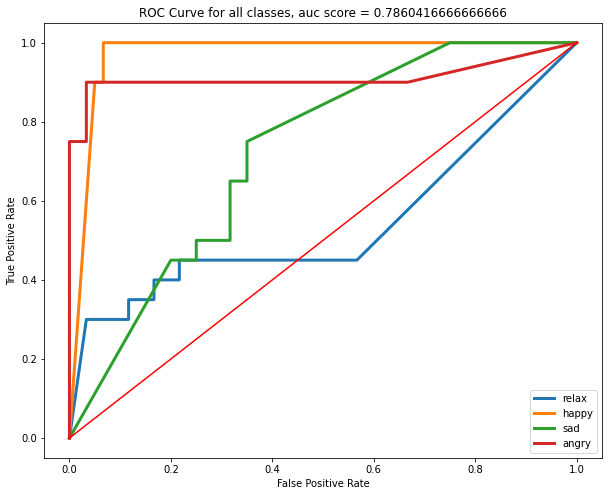

In [ ]:
plot_roc_curve_all(y_true, y_prob,4,(10,8))

# Network 2 hidden layer 512, 64 Relue as Act. Func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(
            nn.BatchNorm1d(50),
            nn.Dropout(0.1),
            nn.Linear(50, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Dropout(0.1),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),

            nn.Dropout(0.1),
            nn.Linear(64, 4),
            nn.BatchNorm1d(4),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

## add optimizar and loss function

In [ ]:
ann_model = Net()
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

## Training

In [ ]:
num_epochs = 100
loss_per_epoch = np.array([])
acc_per_epoch = np.array([])
for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    lpe,ape = evaluate(ann_model, val_loader)
    loss_per_epoch = np.append(loss_per_epoch,lpe)
    acc_per_epoch = np.append(acc_per_epoch,ape)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Average Val Loss: 0.6130, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.5807, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.5558, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.4419, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4658, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.3806, Val Accuracy: 30/32 (93.750%)


Average Val Loss: 0.3946, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.3987, Val Accuracy: 30/32 (93.750%)


Average Val Loss: 0.3882, Val Accuracy: 30/32 (93.750%)


Average Val Loss: 0.4016, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.3834, Val Accuracy: 30/32 (93.750%)


Average Val Loss: 0.3906, Val Accuracy: 30/32 (93.750%)


Average Val Loss: 0.3769, Val Accuracy: 31/32 (96.875%)


Average Val Loss: 0.3839, Val Accuracy: 31/32 (96.875%)


Average Val Loss: 0.3705, Val Accuracy: 31/32 (96.875%)


Average Val Loss: 0.3814, Val Accuracy: 31/32 (96.875%)


Average Val Loss: 0.3793, Val Accuracy: 31/32 (96.875%)


Average Val L

### Training Plot

Text(0, 0.5, 'Loss')

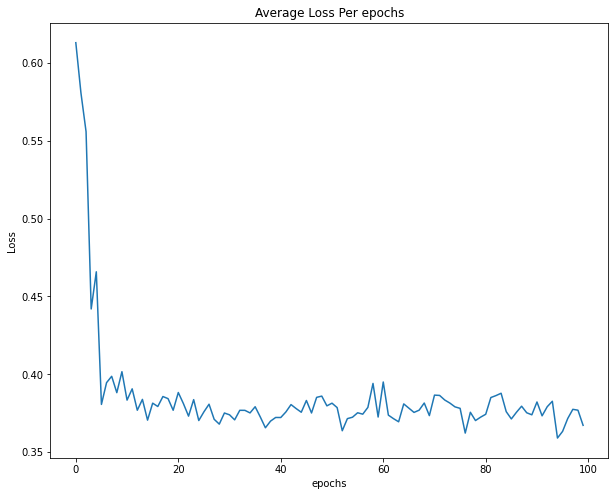

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),loss_per_epoch)
plt.title('Average Loss Per epochs')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

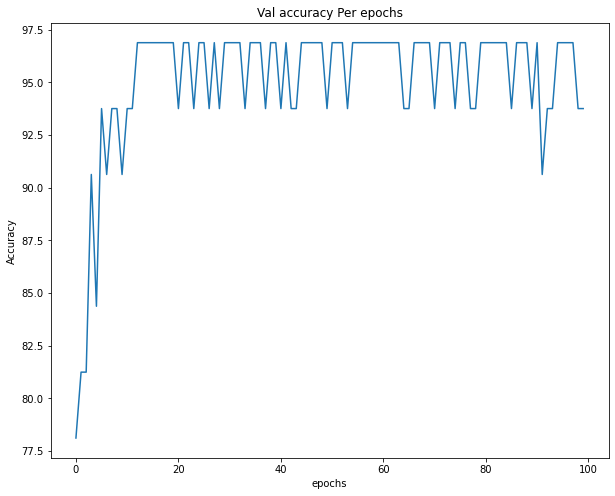

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),acc_per_epoch)
plt.title('Val accuracy Per epochs')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
y_pred, y_true, y_prob = get_output(ann_model,test_loader)


Average Val Loss: 0.5921, Val Accuracy: 60/80 (75.000%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## report classification

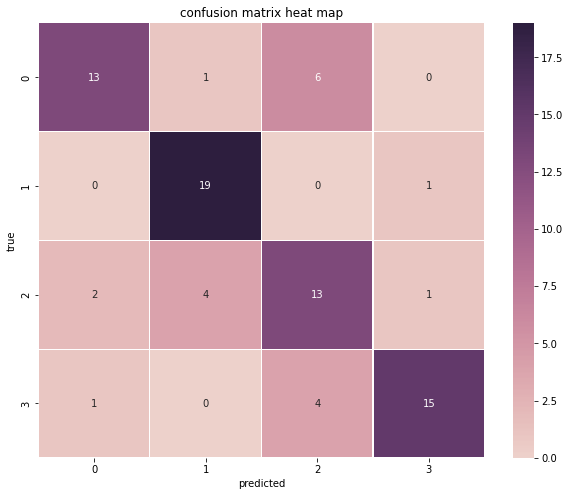

In [ ]:
# Make the confusion matrix
confusion_plot(y_true,y_pred)

In [ ]:
generate_classification_report(y_true,y_pred)

,Label,f1-score,precision,recall,support
0,0,0.722222,0.65000,0.812500,16.00
1,1,0.863636,0.95000,0.791667,24.00
2,2,0.604651,0.65000,0.565217,23.00
3,3,0.810811,0.75000,0.882353,17.00
accuracy,,0.750000,0.75000,0.750000,0.75
macro avg,,0.750330,0.75000,0.762934,80.00
weighted avg,,0.749670,0.76125,0.750000,80.00


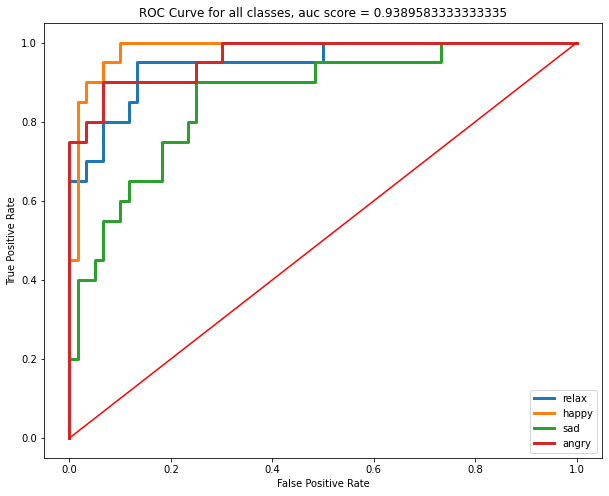

In [ ]:
plot_roc_curve_all(y_true, y_prob,4,(10,8))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(

            nn.Linear(50,64),
            # nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Dropout(),

            nn.Linear(64,512),
            # nn.BatchNorm1d(512),
            nn.Tanh(),
            nn.Dropout(),

            nn.Linear(512,64),
            # nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Dropout(),

            nn.Linear(64,32),
            # nn.BatchNorm1d(64),
            nn.Tanh(),
            nn.Dropout(),


            nn.Linear(32,4),
            # nn.BatchNorm1d(4),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

# Network 2 hidden layer 512, 64 tanh as Act. Func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(
            nn.BatchNorm1d(50),
            nn.Dropout(0.1),
            nn.Linear(50, 512),
            nn.BatchNorm1d(512),
            nn.Tanh(),

            nn.Dropout(0.1),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Tanh(),

            nn.Dropout(0.1),
            nn.Linear(64, 4),
            nn.BatchNorm1d(4),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

## add optimizar and loss function

In [ ]:
ann_model = Net()
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

## Training

In [ ]:
num_epochs = 100
loss_per_epoch = np.array([])
acc_per_epoch = np.array([])
for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    lpe,ape = evaluate(ann_model, val_loader)
    loss_per_epoch = np.append(loss_per_epoch,lpe)
    acc_per_epoch = np.append(acc_per_epoch,ape)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Average Val Loss: 0.6875, Val Accuracy: 25/32 (78.125%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.6248, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.5155, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.4804, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5183, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.4872, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4643, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4583, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4566, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4536, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.4515, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4498, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4436, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4403, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4437, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4420, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4412, Val Accuracy: 29/32 (90.625%)


Average Val Loss: 0.4381, Val Accuracy: 29/32 (90.625%)


Average Val L

### Training Plot

Text(0, 0.5, 'Loss')

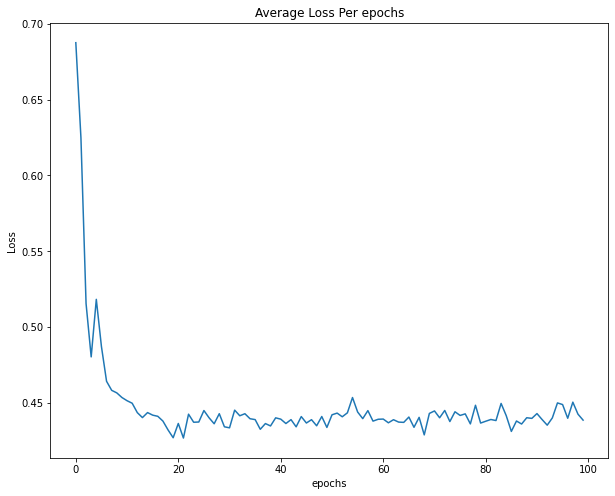

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),loss_per_epoch)
plt.title('Average Loss Per epochs')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

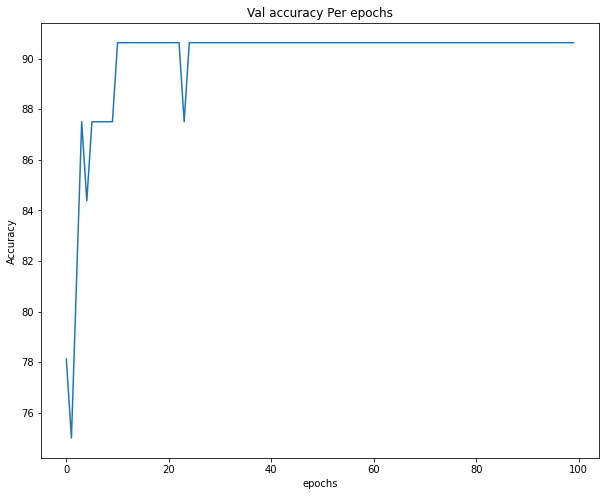

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),acc_per_epoch)
plt.title('Val accuracy Per epochs')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
y_pred, y_true, y_prob = get_output(ann_model,test_loader)


Average Val Loss: 0.5725, Val Accuracy: 66/80 (82.500%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## report classification

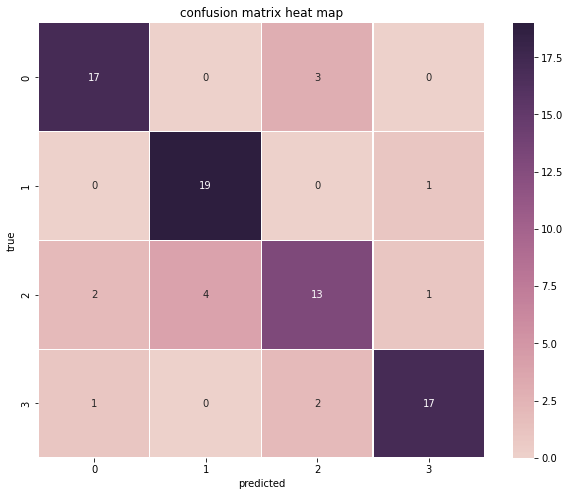

In [ ]:
# Make the confusion matrix
confusion_plot(y_true,y_pred)

In [ ]:
generate_classification_report(y_true,y_pred)

,Label,f1-score,precision,recall,support
0,0,0.850000,0.85000,0.850000,20.000
1,1,0.883721,0.95000,0.826087,23.000
2,2,0.684211,0.65000,0.722222,18.000
3,3,0.871795,0.85000,0.894737,19.000
accuracy,,0.825000,0.82500,0.825000,0.825
macro avg,,0.822432,0.82500,0.823262,80.000
weighted avg,,0.827568,0.83375,0.825000,80.000


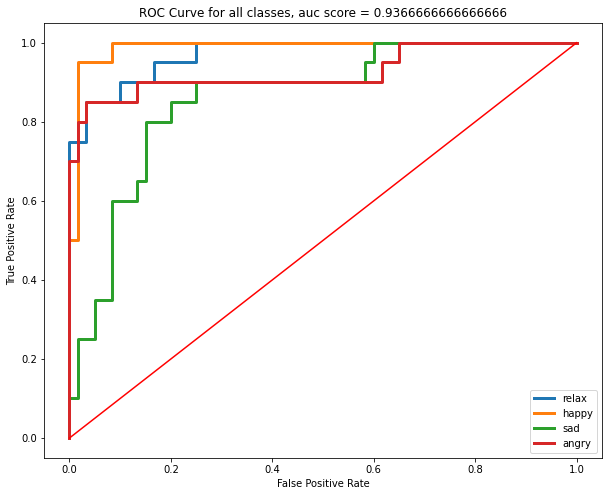

In [ ]:
plot_roc_curve_all(y_true, y_prob,4,(10,8))

# Network 2 hidden layer 512, 64 sigmoid as Act. Func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(
            nn.BatchNorm1d(50),
            nn.Dropout(0.1),
            nn.Linear(50, 512),
            nn.BatchNorm1d(512),
            nn.Sigmoid(),

            nn.Dropout(0.1),
            nn.Linear(512, 64),
            nn.BatchNorm1d(64),
            nn.Sigmoid(),

            nn.Dropout(0.1),
            nn.Linear(64, 4),
            nn.BatchNorm1d(4),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

## add optimizar and loss function

In [ ]:
ann_model = Net()
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

## Training

In [ ]:
num_epochs = 100
loss_per_epoch = np.array([])
acc_per_epoch = np.array([])
for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    lpe,ape = evaluate(ann_model, val_loader)
    loss_per_epoch = np.append(loss_per_epoch,lpe)
    acc_per_epoch = np.append(acc_per_epoch,ape)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 0.6680, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.6005, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.5730, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.6095, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.5005, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5783, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.5661, Val Accuracy: 26/32 (81.250%)


Average Val Loss: 0.5408, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5329, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5250, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5163, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.5087, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5123, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5007, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5039, Val Accuracy: 28/32 (87.500%)


Average Val Loss: 0.5026, Val Accuracy: 27/32 (84.375%)


Average Val Loss: 0.5031, Val Accuracy: 28/32 (87.500%)


Average Val L

### Training Plot

Text(0, 0.5, 'Loss')

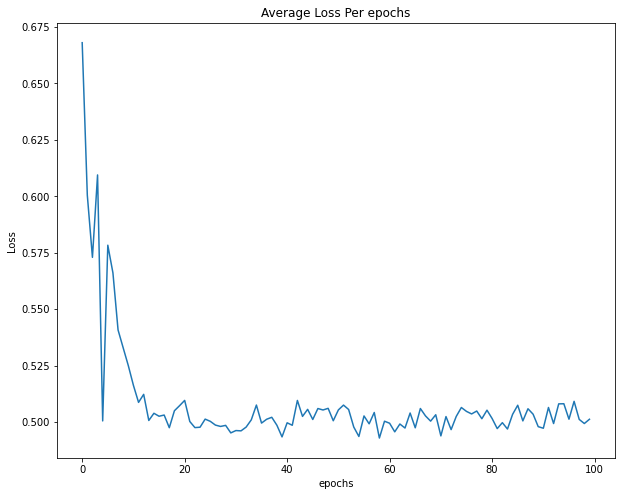

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),loss_per_epoch)
plt.title('Average Loss Per epochs')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

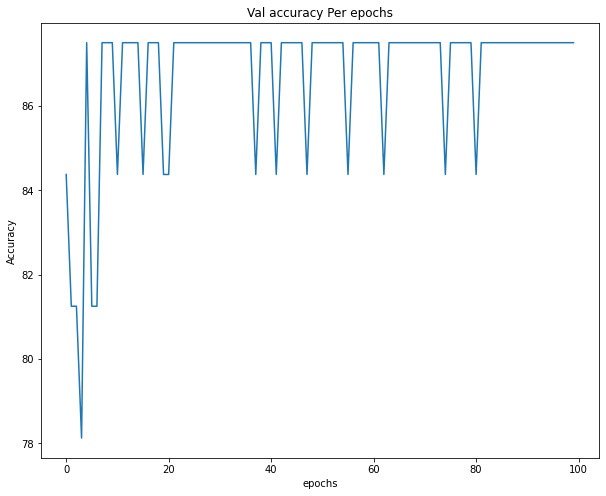

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),acc_per_epoch)
plt.title('Val accuracy Per epochs')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
y_pred, y_true, y_prob = get_output(ann_model,test_loader)


Average Val Loss: 0.6028, Val Accuracy: 66/80 (82.500%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## report classification

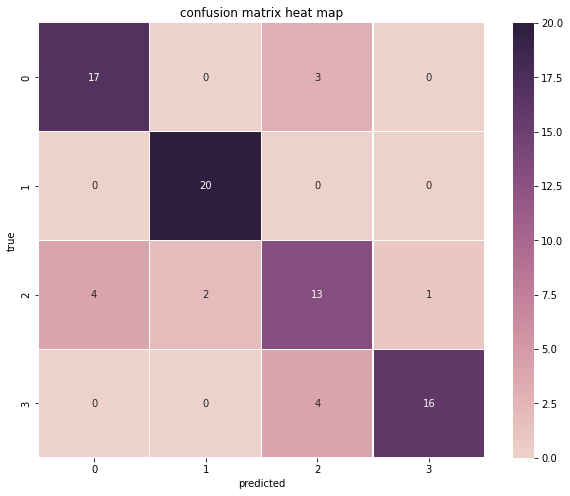

In [ ]:
# Make the confusion matrix
confusion_plot(y_true,y_pred)

In [ ]:
generate_classification_report(y_true,y_pred)

,Label,f1-score,precision,recall,support
0,0,0.829268,0.850000,0.809524,21.000
1,1,0.952381,1.000000,0.909091,22.000
2,2,0.650000,0.650000,0.650000,20.000
3,3,0.864865,0.800000,0.941176,17.000
accuracy,,0.825000,0.825000,0.825000,0.825
macro avg,,0.824129,0.825000,0.827448,80.000
weighted avg,,0.825871,0.830625,0.825000,80.000


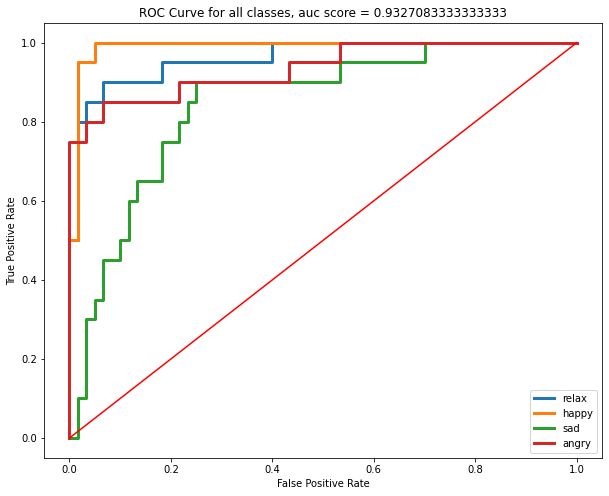

In [ ]:
plot_roc_curve_all(y_true, y_prob,4,(10,8))

# Network 3 hidden layer 256, 128, 64 ReLU as Act. Func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(
            nn.Dropout(0.1),

            nn.Linear(50,256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256,128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128,64),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.Linear(64,4),
            nn.Dropout(0.1),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

## add optimizar and loss function

In [ ]:
ann_model = Net()
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

## Training

In [ ]:
num_epochs = 100
loss_per_epoch = np.array([])
acc_per_epoch = np.array([])
for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    lpe,ape = evaluate(ann_model, val_loader)
    loss_per_epoch = np.append(loss_per_epoch,lpe)
    acc_per_epoch = np.append(acc_per_epoch,ape)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "



Average Val Loss: 1.1513, Val Accuracy: 18/32 (56.250%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 1.0231, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 1.2026, Val Accuracy: 17/32 (53.125%)


Average Val Loss: 0.9940, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9797, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9579, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.9563, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.9614, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.9623, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.9625, Val Accuracy: 25/32 (78.125%)


Average Val Loss: 0.9891, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9937, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9857, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9865, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9868, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9877, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9867, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 0.9868, Val Accuracy: 24/32 (75.000%)


Average Val L

### Training Plot

Text(0, 0.5, 'Loss')

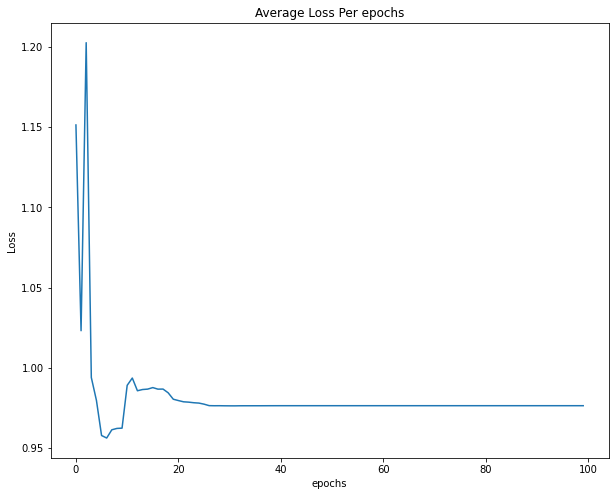

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),loss_per_epoch)
plt.title('Average Loss Per epochs')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

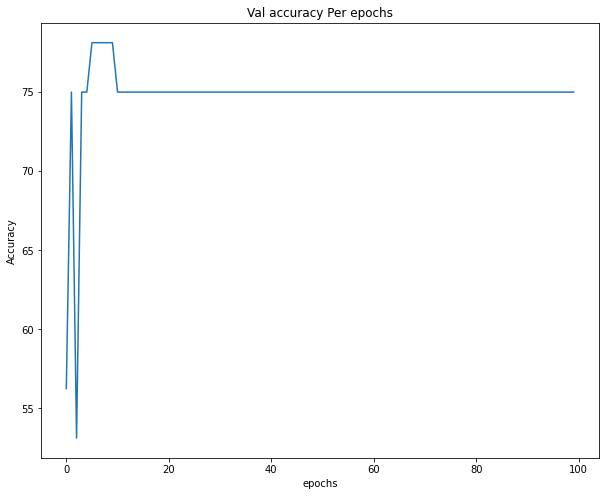

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),acc_per_epoch)
plt.title('Val accuracy Per epochs')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
y_pred, y_true, y_prob = get_output(ann_model,test_loader)


Average Val Loss: 1.0297, Val Accuracy: 57/80 (71.250%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## report classification

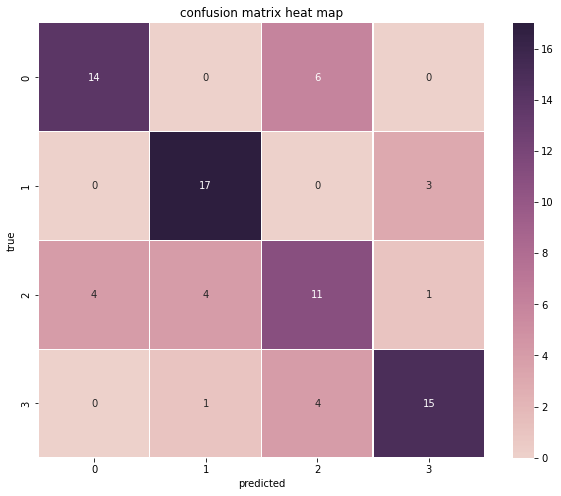

In [ ]:
# Make the confusion matrix
confusion_plot(y_true,y_pred)

In [ ]:
generate_classification_report(y_true,y_pred)

,Label,f1-score,precision,recall,support
0,0,0.736842,0.70000,0.777778,18.0000
1,1,0.809524,0.85000,0.772727,22.0000
2,2,0.536585,0.55000,0.523810,21.0000
3,3,0.769231,0.75000,0.789474,19.0000
accuracy,,0.712500,0.71250,0.712500,0.7125
macro avg,,0.713046,0.71250,0.715947,80.0000
weighted avg,,0.711954,0.71375,0.712500,80.0000


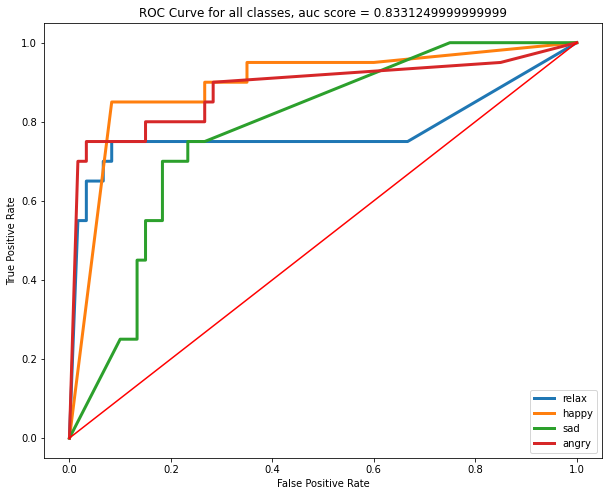

In [ ]:
plot_roc_curve_all(y_true, y_prob,4,(10,8))

# Network 4 hidden layer 64, 512, 64, 32 ReLU as Act. Func.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_block = nn.Sequential(
            nn.Dropout(0.1),

            nn.Linear(50,64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64,512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512,64),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(64,32),
            nn.ReLU(),
            nn.Dropout(0.1),


            nn.Linear(32,4),
            nn.Softmax(dim=1),
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        
        return x

## add optimizar and loss function

In [ ]:
ann_model = Net()
if torch.cuda.is_available():
    ann_model = ann_model.cuda()
ann_model

optimizer = optim.Adam(params=ann_model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

if torch.cuda.is_available():
    criterion = criterion.cuda()

## Training

In [ ]:
num_epochs = 100
loss_per_epoch = np.array([])
acc_per_epoch = np.array([])
for n in range(num_epochs):
    train_model(ann_model, train_loader, n)
    lpe,ape = evaluate(ann_model, val_loader)
    loss_per_epoch = np.append(loss_per_epoch,lpe)
    acc_per_epoch = np.append(acc_per_epoch,ape)

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: 1.0279, Val Accuracy: 24/32 (75.000%)


Average Val Loss: 1.0871, Val Accuracy: 21/32 (65.625%)


Average Val Loss: 1.0863, Val Accuracy: 21/32 (65.625%)


Average Val Loss: 1.1499, Val Accuracy: 19/32 (59.375%)


Average Val Loss: 1.1185, Val Accuracy: 20/32 (62.500%)


Average Val Loss: 1.3374, Val Accuracy: 13/32 (40.625%)


Average Val Loss: 1.3572, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3417, Val Accuracy: 13/32 (40.625%)


Average Val Loss: 1.3683, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3689, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3694, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3694, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3697, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3701, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3702, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3702, Val Accuracy: 12/32 (37.500%)


Average Val Loss: 1.3689, Val Accuracy: 12/32 (37.500%)


Average Val L

### Training Plot

Text(0, 0.5, 'Loss')

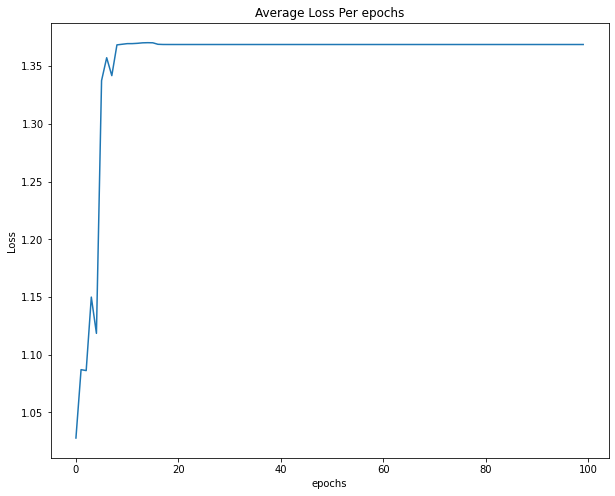

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),loss_per_epoch)
plt.title('Average Loss Per epochs')
plt.xlabel("epochs")
plt.ylabel("Loss")

Text(0, 0.5, 'Accuracy')

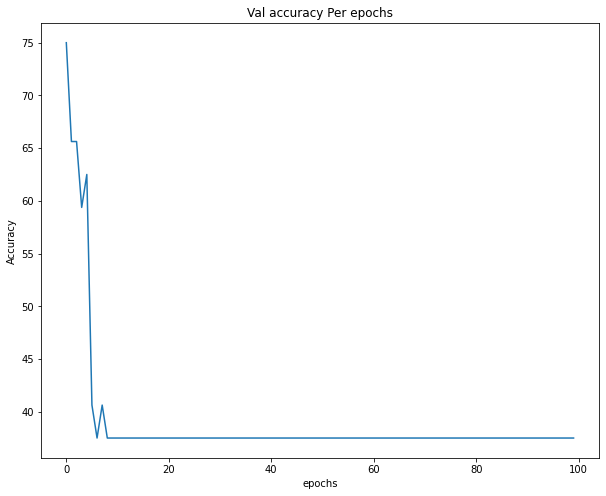

In [ ]:
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(range(num_epochs),acc_per_epoch)
plt.title('Val accuracy Per epochs')
plt.xlabel("epochs")
plt.ylabel("Accuracy")

In [ ]:
y_pred, y_true, y_prob = get_output(ann_model,test_loader)


Average Val Loss: 1.3818, Val Accuracy: 29/80 (36.250%)



/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


## report classification

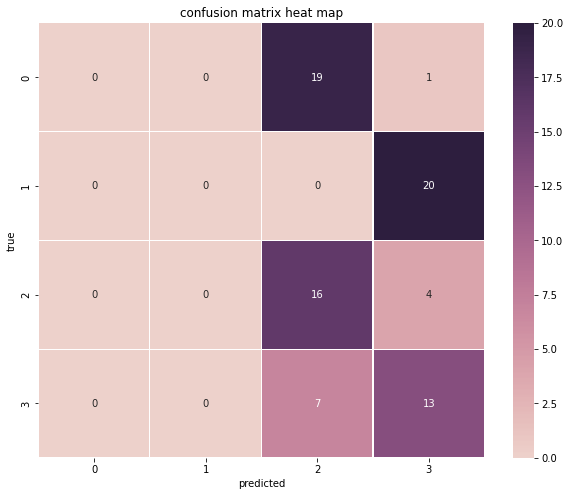

In [ ]:
# Make the confusion matrix
confusion_plot(y_true,y_pred)

In [ ]:
generate_classification_report(y_true,y_pred)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Label,f1-score,precision,recall,support
0,0,0.000000,0.00000,0.000000,0.0000
1,1,0.000000,0.00000,0.000000,0.0000
2,2,0.516129,0.80000,0.380952,42.0000
3,3,0.448276,0.65000,0.342105,38.0000
accuracy,,0.362500,0.36250,0.362500,0.3625
macro avg,,0.241101,0.36250,0.180764,80.0000
weighted avg,,0.483899,0.72875,0.362500,80.0000


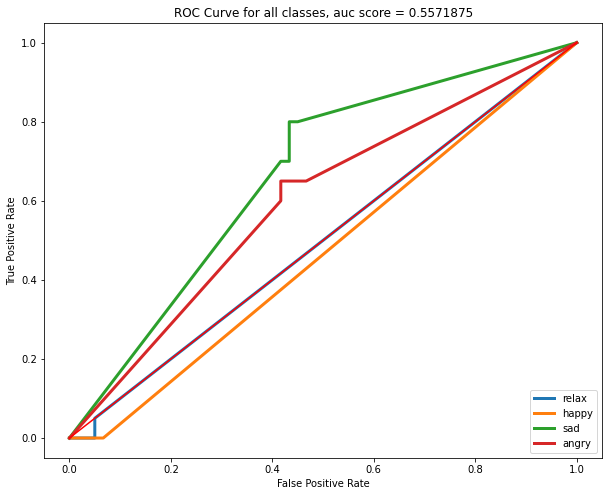

In [ ]:
plot_roc_curve_all(y_true, y_prob,4,(10,8))